# Empirical models with scipy trust-constr:
## Identifying equivalent circuit parameters using bounds, nonlinear constraints, and gradient-based optimisers

Here, we provide a short example of how to identify equivalent-circuit parameters using the [scipy trust-constr](https://docs.scipy.org/doc/scipy-1.14.0/reference/generated/scipy.optimize.minimize.html) method -- a trust-region based optimiser that can handle parameter bounds, and both linear and nonlinear constraints. As shown here, these turn out to be useful tools for fitting empirical battery models.

### Importing libraries

If you don't already have PyBOP installed, check out the [installation guide](https://pybop-docs.readthedocs.io/en/latest/installation.html) first.

We begin by importing the necessary libraries.

In [ ]:
import numpy as np
import scipy.optimize

import pybop

### Initialising the model and parameters

PyBOP needs to know some model parameters in order to run. Where these are unknown, and to be fitted, any sensible initial guess can be provided.

Model parameters can either be defined using a PyBOP ```ParameterSet``` object, or by importing from a JSON file. For clarity, we will define the initial parameters from a ```ParameterSet```.

Here, we'll fit a Thevenin model with two RC pairs. The initial parameter set must contain all the parameters that the PyBaMM model will use, and therefore it will need definitions for each circuit component, and each RC pair overpotential.

In [ ]:
parameter_set = {
    "chemistry": "ecm",
    "Initial SoC": 0.5,
    "Initial temperature [K]": 25 + 273.15,
    "Cell capacity [A.h]": 5,
    "Nominal cell capacity [A.h]": 5,
    "Ambient temperature [K]": 25 + 273.15,
    "Current function [A]": 5,
    "Upper voltage cut-off [V]": 4.2,
    "Lower voltage cut-off [V]": 3.0,
    "Cell thermal mass [J/K]": 1000,
    "Cell-jig heat transfer coefficient [W/K]": 10,
    "Jig thermal mass [J/K]": 500,
    "Jig-air heat transfer coefficient [W/K]": 10,
    "Open-circuit voltage [V]": pybop.empirical.Thevenin().default_parameter_values[
        "Open-circuit voltage [V]"
    ],
    "R0 [Ohm]": 0.01,
    "Element-1 initial overpotential [V]": 0,
    "Element-2 initial overpotential [V]": 0,
    "R1 [Ohm]": 0.005,
    "R2 [Ohm]": 0.0003,
    "C1 [F]": 10000,
    "C2 [F]": 5000,
    "Entropic change [V/K]": 0.0004,
}

model = pybop.empirical.Thevenin(
    parameter_set=parameter_set, options={"number of rc elements": 2}
)

### Generating synthetic data

Ordinarily, we would want to fit models to experimental data. For simplicity we'll use our model to generate some synthetic data, by simulating a discharge and corrupting the results with random noise. We will then use this synthetic data to form a PyBOP ```Dataset```, from which we can demonstrate the model fitting procedure.

In [ ]:
sigma = 0.001
t_eval = np.linspace(0, 500, 500)
values = model.predict(t_eval=t_eval)
corrupt_values = values["Voltage [V]"].data + np.random.normal(0, sigma, len(t_eval))

# Form dataset
dataset = pybop.Dataset(
    {
        "Time [s]": t_eval,
        "Current function [A]": values["Current [A]"].data,
        "Voltage [V]": corrupt_values,
    }
)

### Identifying parameters

Now for the fun part! We begin by defining the parameters that we want to fit. In this case, it's the series resistance $R_0$, and the RC parameters $R_1$ and $C_1$. Since we don't want to make things too easy, we've set up our parameters to have quite different values to those used in simulating the data.

In [ ]:
parameters = pybop.Parameters(
    pybop.Parameter(
        "R0 [Ohm]",
        prior=pybop.Gaussian(2e-3, 1e-4),
        bounds=[1e-4, 1e-1],
    ),
    pybop.Parameter(
        "R1 [Ohm]",
        prior=pybop.Gaussian(1e-3, 1e-4),
        bounds=[1e-5, 1e-2],
    ),
    pybop.Parameter(
        "C1 [F]",
        prior=pybop.Gaussian(5000, 300),
        bounds=[2500, 5e4],
    ),
)

We can now set up a problem and cost for identifying these parameters from our synthetic dataset.

In [ ]:
problem = pybop.FittingProblem(model, parameters, dataset)
cost = pybop.SumSquaredError(problem)

The voltage over any given RC branch will evolve over a timescale $\tau = R \times C$. The data we work with will place some limits on which parameters can realistically be identified. We can't expect to fit fast timescales with low sample-rate data; similarly, we can't get good parameters for a long timescale if we only have short amounts of data. 

To illustrate, imagine trying to fit a timescale of $\tau=0.1$ s from data with a sample rate of 1 Hz. Virtually all the interesting dynamics will have happened over the course of a single sample, so there's not enough information to work from for parameter identification. Similarly, it would be unreasonable to fit a timescale of $\tau=1000$ s from only one minute of data; across the range of data that we have, the dynamics will have barely changed, giving us very little to work from for fitting $R$ and $C$.

In general therefore, we need to be careful to make sure our parameter values are sensible. To make sure that the optimiser doesn't propose excessively long or short timescales, we can use nonlinear constraints. The ```scipy.optimize.NonlinearConstraint``` function handles this for us.

In [ ]:
tau_constraint = scipy.optimize.NonlinearConstraint(lambda x: x[1] * x[2], 5, 750)

Let's dig into what's going on here.

The nonlinear constraint will receive a parameter vector from PyBOP. We know from our parameters list that parameter 0 will be $R_0$, 
parameter 1 will be $R_1$, and parameter 2 will be $C_1$. We can therefore compute the RC timescale $R_1 \times C_1$ using ```lambda x: x[1] * x[2]```. Next, we tell scipy that we want this to be constrained to the range $5\leq R_1 \times C_1 \leq 750$. There's a lot of flexibility in our choice of lower and upper bounds, however these are reasonable numbers given our sampling rate (1 Hz), and data time-span (500 s).

Now all we need to do is set up an optimiser to use this.

In [ ]:
optim = pybop.SciPyMinimize(
    cost,
    method="trust-constr",
    constraints=tau_constraint,
    max_iterations=100,
)

Note that ```COBYLA```, ```COBYQA```, and ```SLSQP``` can also be used as the method; these are all different Scipy optimisers with constraint capabilities.

Finally, we run the parameteriser, and plot some results. Don't worry if the solver sometimes terminates early -- this happens when the model receives a bad set of parameters, but PyBOP will catch and handle these cases automatically.

Estimated parameters: [8.41410880e-03 6.45916310e-03 4.57841684e+03]


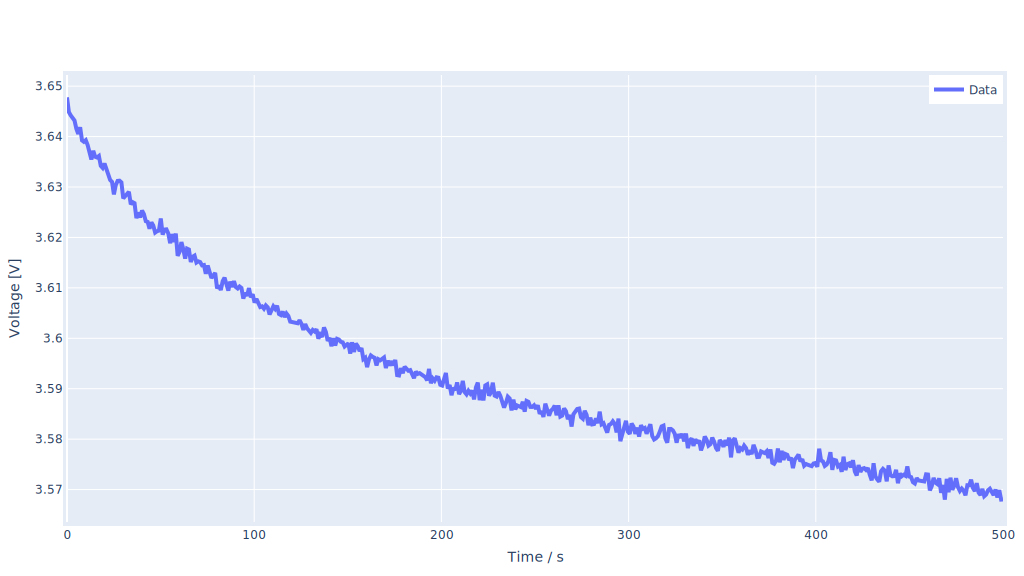

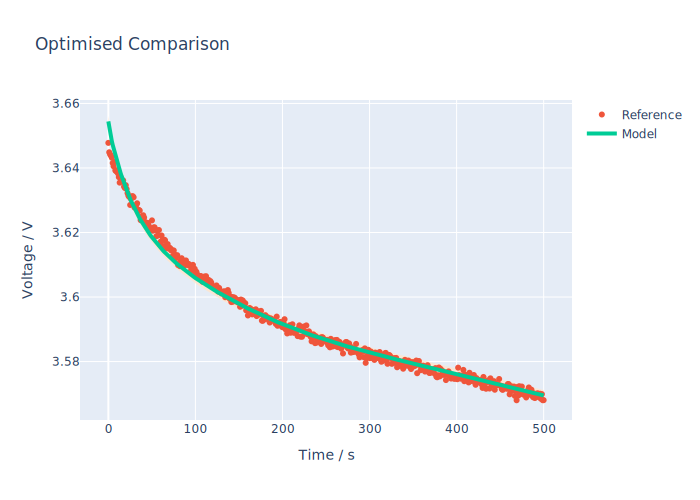

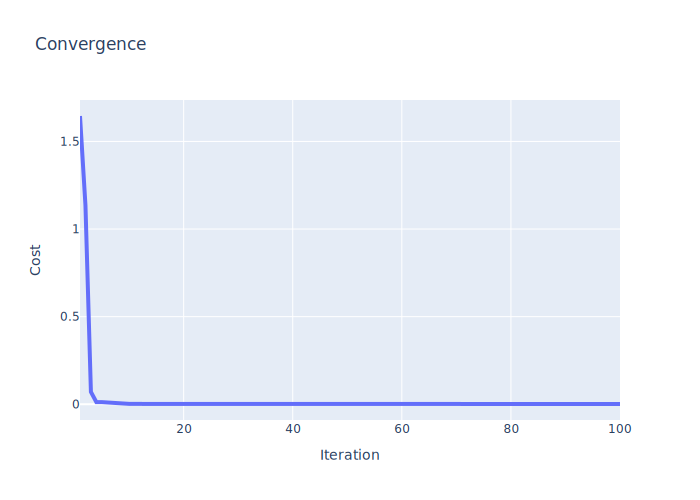

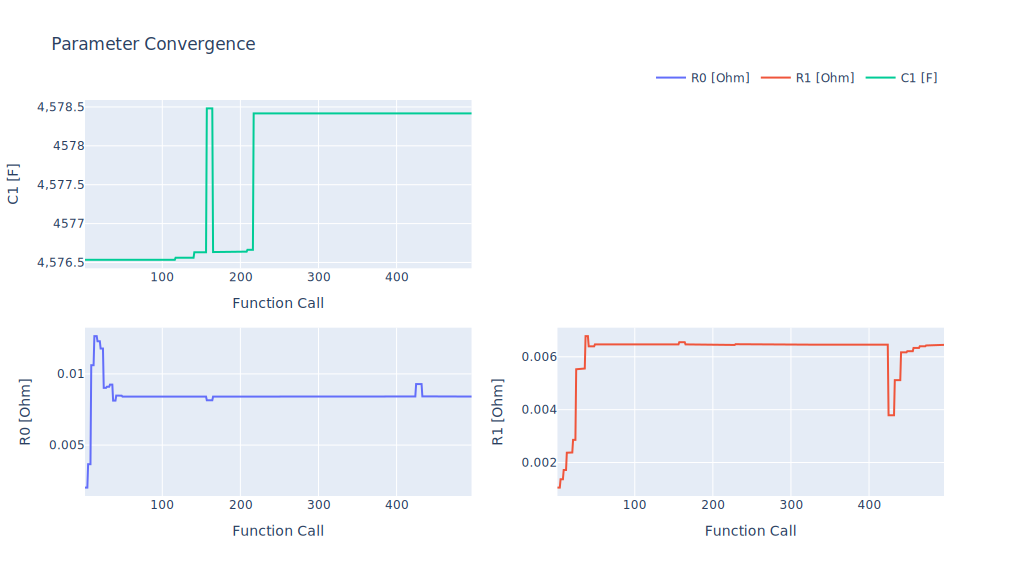

In [ ]:
x, final_cost = optim.run()
print("Estimated parameters:", x)

# Plot the time series
pybop.plot_dataset(dataset)

# Plot the timeseries output
pybop.quick_plot(problem, problem_inputs=x, title="Optimised Comparison")

# Plot convergence
pybop.plot_convergence(optim)
# Plot the parameter traces
pybop.plot_parameters(optim);

### Conclusion

Here, we have considered parameter estimation for an equivalent circuit model. We have introduced some issues of practical identifiability, whereby particularly fast or slow timescales can't be parameterised very well. To work around this challenge, nonlinear constraints have been implemented.

A difficulty here is that fitting RC parameters is a [sloppy problem](https://sethna.lassp.cornell.edu/Sloppy/FittingExponentials.html) -- there's a range of timescales that will all produce reasonable looking results, and an optimiser will struggle to choose any one timescale over another. Gradient-free methods such as ```pybop.CMAES``` may do a better job of fitting timescales. Nevertheless, the resistance values can be fitted very accurately with gradient-based methods, whereas gradient-free methods don't always come up with such a good solution.

The ideal approach would be to fit resistances with gradient-based or ordinary least-squares methods, and timescales using gradient-free optimisers. In the absence of this approach, general recommendations are as follows...

+ If good initial guesses are available for the RC timescales, use a gradient-based method in the way we've done here, as it'll typically give the most accurate fit;
+ Otherwise, use a gradient-free method to estimate timescales, then maybe consider moving back to a gradient-based method!